In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import random
import netCDF4 as nc
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats  
from decimal import Decimal

In [46]:
temperature = xr.open_dataset('/cluster/home/maikents/sinmod_combine_years/temp_bottom_layer.nc')

In [11]:
#Load transformed (EMOD grid) coral data
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

coral_x_emod = coral_data_emod['x']
coral_y_emod = coral_data_emod['y']

In [28]:
#Load sinmod data
sinmod_data = xr.open_dataset("/cluster/home/maikents/sinmod_features_masters/sinmod_bottom_features_emod_grid.nc")
sinmod_data_copy = sinmod_data.copy()

In [45]:
temp_sundahl = sinmod_data_copy['bottom_temperature_sundahl_features']

In [46]:
temp_sundahl = temp_sundahl.sel(stat='max_(mean_oct_dec)')

In [47]:
temp_sundahl_df = temp_sundahl.to_dataframe()

In [48]:
temp_sundahl_df.drop('stat', axis=1, inplace=True)

In [49]:
temp_sundahl_df = temp_sundahl_df.dropna(subset=['bottom_temperature_sundahl_features'])


In [29]:
sinmod_data_copy = sinmod_data_copy.sel(stat='mean')

In [30]:
sinmod_df = sinmod_data_copy.to_dataframe()
sinmod_df = sinmod_df.reset_index()
sinmod_df['y'] = sinmod_df['y'].round().astype(int)
sinmod_df['x'] = sinmod_df['x'].round().astype(int)
sinmod_df = sinmod_df.set_index(['y', 'x'])
nan_indices = sinmod_df[sinmod_df['bottom_temperature_features'].isna()].index
sinmod_df_cleaned = sinmod_df.dropna(subset=['bottom_temperature_features'])
sinmod_df = sinmod_df_cleaned.sort_values(by="y")

In [32]:
print(sinmod_df.columns)

Index(['stat', 'spatial_ref', 'bottom_temperature_sundahl_features',
       'bottom_temperature_features', 'bottom_salinity_features',
       'bottom_current_features', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle'],
      dtype='object')


In [33]:
sinmod_df.drop('stat', axis=1, inplace=True)

In [34]:
sinmod_df.drop('spatial_ref', axis=1, inplace=True)

In [4]:
#Load EMOD data
emod_data = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc")
emod_data_copy = emod_data.copy()

In [5]:
print(list(emod_data_copy.variables))

['x', 'y', 'aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope']


In [6]:
#Handle the EMOD data 
emod_df = emod_data_copy.to_dataframe()
emod_df = emod_df.reset_index()
emod_df['y'] = emod_df['y'].round().astype(int)
emod_df['x'] = emod_df['x'].round().astype(int)
emod_df = emod_df.set_index(['y', 'x'])
nan_indices = emod_df[emod_df['bathymetry_32N_Clip_sample'].isna()].index
emod_df_cleaned = emod_df.dropna(subset=['bathymetry_32N_Clip_sample'])
emod_df = emod_df_cleaned.sort_values(by="y")

In [5]:
#Current aspect angle
#sinmod_bottom = xr.open_dataset('/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc')
sinmod_bottom = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/ready_for_training/SINMOD_bottom_features_emod_grid2.nc")

current_aspect_angle = sinmod_bottom['current_aspect_angle']

In [6]:
current_df = current_aspect_angle.to_dataframe()

In [7]:
current_df_cleaned = current_df.dropna(subset=['current_aspect_angle'])


In [2]:
sediment_nitrate = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/nitrate_features_reprojected_features_emod_grid.nc')

In [3]:
sediment_nitrate = sediment_nitrate['sediment_nitrate_features'].isel(stat=0)

In [4]:
sediment_nitrate_df = sediment_nitrate.to_dataframe()

In [5]:
sediment_nitrate_df.drop('stat', axis=1, inplace=True)

In [6]:
sediment_nitrate_df_cleaned = sediment_nitrate_df.dropna(subset=['sediment_nitrate_features'])

In [20]:
sediment_silicate = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/silicate_features_reprojected_features_emod_grid.nc')

In [21]:
sediment_silicate = sediment_silicate['sediment_silicate_features'].isel(stat=0)

In [22]:
sediment_silicate_df = sediment_silicate.to_dataframe()

In [23]:
sediment_silicate_df.drop('stat', axis=1, inplace=True)

In [24]:
sediment_silicate_df_cleaned = sediment_silicate_df.dropna(subset=['sediment_silicate_features'])

In [60]:
chlor_a_sinmod = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/surface_chlorophyll_2019_2022_2023_features_emod_grid.nc')

In [56]:
print(chlor_a_sinmod)

<xarray.Dataset> Size: 966MB
Dimensions:           (stat: 3, x: 8325, y: 9671)
Coordinates:
  * stat              (stat) <U15 180B 'mean' ... '90th_percentile'
  * x                 (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.92e+05
  * y                 (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06
Data variables:
    spatial_ref       int64 8B ...
    chlor_a_features  (stat, y, x) float32 966MB ...


In [61]:
chlor_a_sinmod= chlor_a_sinmod['chlor_a_features'].isel(stat=0)

In [62]:
chlor_a_sinmod_df = chlor_a_sinmod.to_dataframe()

In [63]:
chlor_a_sinmod_df.drop('stat', axis=1, inplace=True)


In [64]:
print(chlor_a_sinmod_df)

                             chlor_a_features
y            x                               
7.539188e+06 -65456.088686                NaN
             -65365.088686                NaN
             -65274.088686                NaN
             -65183.088686                NaN
             -65092.088686                NaN
...                                       ...
6.659218e+06  691663.911314               NaN
              691754.911314               NaN
              691845.911314               NaN
              691936.911314               NaN
              692027.911314               NaN

[80511075 rows x 1 columns]


In [65]:
chlor_a_sinmod_df_cleaned = chlor_a_sinmod_df.dropna(subset=['chlor_a_features'])

In [49]:
chlor_a_satellite = xr.open_dataset('/cluster/home/maikents/satellite_data/chlor_a_dataset_midnor_features_emod_grid.nc')

In [4]:
print(chlor_a_satellite)

<xarray.Dataset> Size: 2GB
Dimensions:       (y: 9671, x: 8325)
Coordinates:
    spatial_ref   int64 8B ...
  * x             (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.919e+05 6.92e+05
  * y             (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06
Data variables:
    chlor_a_mean  (y, x) float32 322MB ...
    chlor_a_min   (y, x) float64 644MB ...
    chlor_a_max   (y, x) float64 644MB ...


In [50]:
chlor_a_satellite = chlor_a_satellite['chlor_a_mean']

In [51]:
chlor_a_satellite_df = chlor_a_satellite.to_dataframe()

In [52]:
chlor_a_satellite_df_cleaned = chlor_a_satellite_df.dropna(subset=['chlor_a_mean'])

In [53]:
chlor_a_satellite_df_cleaned.drop('spatial_ref', axis=1, inplace=True)


/tmp/ipykernel_2236512/4054683248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chlor_a_satellite_df_cleaned.drop('spatial_ref', axis=1, inplace=True)


In [21]:
print(emod_df.columns)

Index(['aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample',
       'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope'],
      dtype='object')


In [7]:
def permutation_test(x, y, num_permutations=100000):
    observed_diff = np.mean(x) - np.mean(y)
    combined = np.concatenate([x, y])
    count = 0

    #Perform permutations
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        new_diff = np.mean(new_x) - np.mean(new_y)
        if abs(new_diff) >= abs(observed_diff):
            count += 1
    
    p_value_permutation = count / num_permutations
    return observed_diff, p_value_permutation

In [10]:
#Histograms for EMOD data

def plot_histogram_at_coral_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))

    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    for x, y in zip(x_indices, y_indices):
    
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})
    

    values = values[variable_name].dropna().values

    print(f"Number of valid coordinates: {len(valid_coords)} out of {len(coral_data)}")

    if len(values) == 0:
        print("Error: array is empty after dropping NaNs!")
    else:

        #Calculate statistics for coral values
        stats_coral = {
            'mean': np.mean(values),
            'max': np.max(values),
            'min': np.min(values),
            '90th_percentile': np.percentile(values, 90),
            '10th_percentile': np.percentile(values, 10),
            'std': np.std(values, ddof=1), #std
            'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }
       
        print(f"Statistics for {variable_name}:", stats_coral)


    if generate_random:
        no_points = int(len(values))  

        variable_data = emod_df[variable_name]
        valid_data = variable_data.dropna()
        random_indices = np.random.choice(valid_data.index, no_points, replace=False)
        random_values = emod_df.loc[random_indices, variable_name]

        #Calculate statistics for coral values
        random_stats = {
            'mean': np.mean(random_values),
            'max': np.max(random_values),
            'min': np.min(random_values),
            '90th_percentile': np.percentile(random_values, 90),
            '10th_percentile': np.percentile(random_values, 10),
            'std': np.std(random_values, ddof=1), #std
            'cv': np.std(random_values, ddof=1) / np.mean(random_values) if np.mean(random_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for random values: {random_stats}")
        
        # Mann-Whitney U Test
        u_stat, p_value = stats.mannwhitneyu(values, random_values, alternative='two-sided')
        print(f"Mann-Whitney U statistic: {u_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference between coral points and random points is statistically significant (p < 0.05).")
        else:
            print(f"There is no statistically significant difference between coral points and random points (p >= 0.05).")
        
        # Run permutation test
        observed_diff, p_value_permutation = permutation_test(values, random_values)
        p_value_permutation_rounded = Decimal(p_value_permutation)

        
        print(f"Observed Difference in Means: {observed_diff}")
        print(f"Permutation Test p-value: {p_value_permutation_rounded:.20f}")
        
        if p_value_permutation < 0.05:
            print("The difference between coral points and random points is statistically significant (Permutation Test).")
        else:
            print("There is no statistically significant difference between coral points and random points (Permutation Test).")

        from scipy.stats import gaussian_kde
 
        kde_coral = gaussian_kde(values)
        kde_random = gaussian_kde(random_values)
        x = np.linspace(min(values.min(), random_values.min()),
                        max(values.max(), random_values.max()), 1000)
      
        coral_density = kde_coral(x)
        random_density = kde_random(x)

        ratio = coral_density / random_density
        area = np.trapz(ratio, x)
        normalized_ratio = ratio / area
    

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')

        #Endre basert på plottet
        mask = (x >= 0) & (x <= 16)
        x_cut = x[mask]
        normalized_ratio_cut = normalized_ratio[mask]



        
        #plt.plot(x, normalized_ratio, label='Normalized Density Ratio', color='green')
        plt.plot(x_cut, normalized_ratio_cut, label='Normalized Density Ratio', color='green')

        plt.grid(which='both', linestyle='--', color='gray')


        """
        if emod_df is chlor_a_satellite_df_cleaned:
            plt.title("KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio (Chlorophyll-a, satellite)", fontsize=16)
            plt.xlabel('Chlorophyll-a, satellite', fontsize=14)
        elif emod_df is chlor_a_sinmod_df_cleaned:
            plt.title("KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio (Chlorophyll-a, SINMOD)", fontsize=16)
            plt.xlabel('Chlorophyll-a, SINMOD', fontsize=14)
        else:
            plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
            plt.xlabel(f'{variable_name}', fontsize=14) 
            
        """
        #plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
        plt.ylabel("Density", fontsize=14)
        plt.legend()
        


        plt.show()

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')
        plt.grid(which='both', linestyle='--', color='gray')
        plt.ylabel("Density", fontsize=14)
        """
        if emod_df is chlor_a_satellite_df_cleaned:
            plt.title("KDE of Coral Points and Random Points (Chlorophyll-a, satellite)", fontsize=16)
            plt.xlabel('Chlorophyll-a, satellite', fontsize=14)
        elif emod_df is chlor_a_sinmod_df_cleaned:
            plt.title("KDE of Coral Points and Random Points (Chlorophyll-a, SINMOD)", fontsize=16)
            plt.xlabel('Chlorophyll-a, SINMOD', fontsize=14)
        
        else:
            plt.title(f"KDE of Coral Points and Random Points ({variable_name})", fontsize=16)
            plt.xlabel(f'{variable_name}', fontsize=14) 
        """
        #plt.title(f"KDE of Coral Points and Random Points ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14) 
          

        plt.legend()

    return values, random_values




Number of valid coordinates: 718 out of 841
Statistics for sediment_nitrate_features: {'mean': 5.015669, 'max': 18.865417, 'min': 3.0481827, '90th_percentile': 6.859740066528321, '10th_percentile': 3.4986168146133423, 'std': 1.8028218, 'cv': 0.35943794}
Statistics for random values: {'mean': 4.0753736, 'max': 20.642107, 'min': 0.21009083, '90th_percentile': 7.4013041496276895, '10th_percentile': 0.9959184288978576, 'std': 3.0589302, 'cv': 0.7505889}
Mann-Whitney U statistic: 346617.0
p-value: 1.1867719678603523e-29
The difference between coral points and random points is statistically significant (p < 0.05).
Observed Difference in Means: 0.9402952194213867
Permutation Test p-value: 0.00000000000000000000
The difference between coral points and random points is statistically significant (Permutation Test).


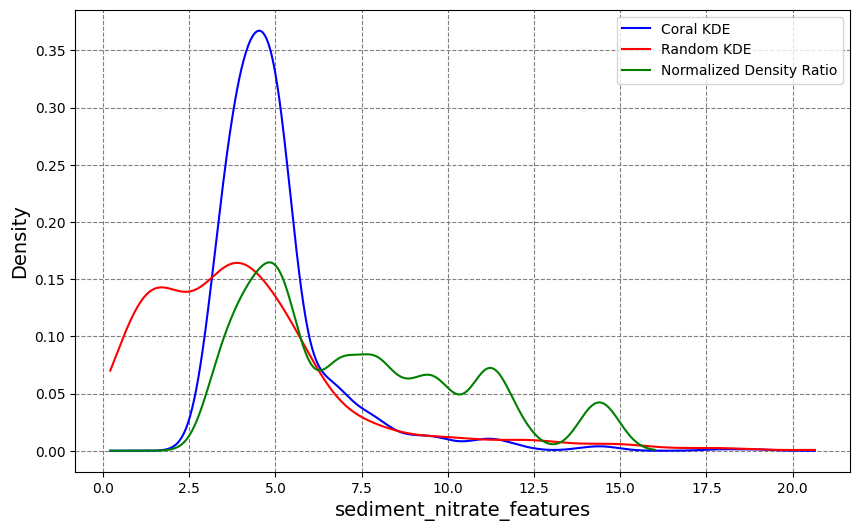

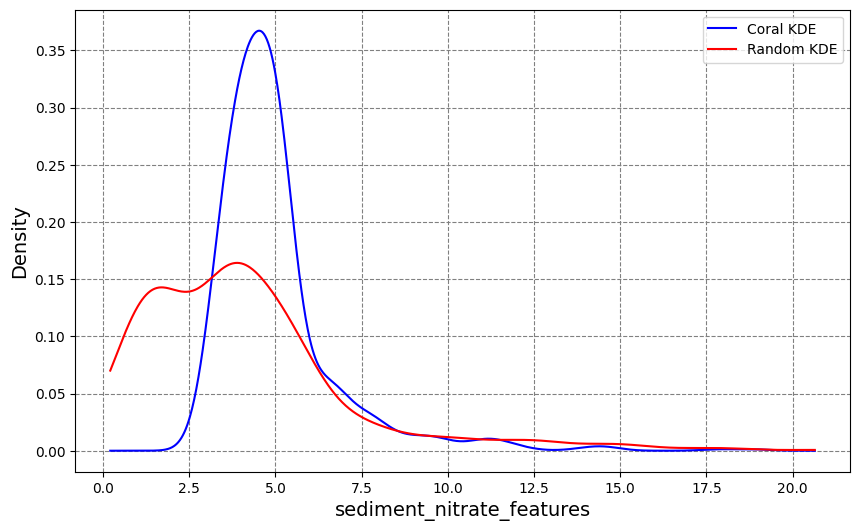

In [12]:
values_sediment_nitrate, random_values_sediment_nitrate = plot_histogram_at_coral_points_emod(sediment_nitrate_df_cleaned, coral_data_emod, 'sediment_nitrate_features', True)